In [1]:
import os
import glob

import pandas as pd
import numpy as np
import datetime

from skimage import io
from datetime import timedelta
from datetime import datetime
from scipy.stats import pearsonr

from netCDF4 import Dataset

# Imports for plotting
import matplotlib.pyplot as plt
import matplotlib.dates as dates
from matplotlib.ticker import NullFormatter 
from matplotlib.ticker import MultipleLocator, FormatStrFormatter 
from matplotlib.dates import MonthLocator
import matplotlib.patheffects as PathEffects

## font sizes

In [2]:
fs_titles = 24
fs_labels = 24
fs_axes = 20
fs_text = 20
fs_legend = 20

## load data histogram dataframe

In [3]:
#mm path
# df_h = pd.read_csv('/Users/megmason/Desktop/outputs/histogram_df.csv',index_col=0)

#ars path
df_h = pd.read_csv('/home/meganmason/Documents/projects/thesis/figures/tables/histogram_df.csv',index_col=0)
# binx = np.arange(0,1000,30) #set bin sizes to have as index
df_h[:5]

# pd.to_datetime(df_h.columns[0]).strftime("%Y")

,2013-04-03,2013-04-29,2013-05-03,2013-05-25,2013-06-01,2013-06-08,2014-03-23,2014-04-07,2014-04-13,2014-04-20,...,2017-03-03,2017-04-01,2017-05-02,2017-06-04,2017-07-09,2017-07-17,2017-07-27,2017-08-16,2018-04-23,2018-05-28
0,11939930,14492016,14149379,10352002,8496363,6813639,14575297,14289932,13801321,11952963,...,3734712,4561493,5505172,7841711,6904534,5011025,2794947,923170,12216054,9257357
30,10604904,10245900,9546177,5854912,4370306,2577140,13885180,13342293,13193806,11192225,...,4187190,4523526,3893722,5937692,4233230,2716576,1278689,373825,12723788,7052135
60,9604871,8875702,7905614,3924401,2761500,1383532,13288261,13005864,13312664,11036612,...,4439869,4241300,3822079,5436903,3382450,2040749,934067,280009,13868724,6170597
90,9199567,7602102,6387717,2706986,1878462,898117,12552175,12854792,13074121,10611180,...,4685584,4272276,4231215,5790431,2828785,1600382,740580,233088,14580365,4943048
120,8776834,6042986,4684999,1842198,1306242,620342,9971570,12308798,10999406,8655352,...,4915874,4584846,4963797,6346478,2315836,1257456,610091,197757,13291083,3377909


## plot histograms

In [4]:
#~~~one for each flight, prior to df_h transpose
# for column in df_h:
#     plt.figure(figsize=(10,3))
#     df_h[column][:-1].plot.bar(width=0.85, align='edge') #bar plot of each column (minus the last row)
#     plt.title(str(column), fontsize=fs_titles)
#     plt.xlabel('snow depth [cm]', fontsize=fs_axes); plt.ylabel('frequency', fontsize=fs_axes)
#     plt.xlim(-.5,34) #34 is # of bins to display -- 34x30cm = 1000+cm (i.e. 10m)

## Transpose and make flight dates index as datetime

In [5]:
df_h = df_h.T #if you run this multiple times it keeps transposing....duhh

In [6]:
df_h.set_index(pd.to_datetime(df_h.index), inplace=True) #inplace doesn't make a copy, overwrites
df_h[:5]

,0,30,60,90,120,150,180,210,240,270,...,2220,2250,2280,2310,2340,2370,2400,2430,2460,zeros
2013-04-03,11939930,10604904,9604871,9199567,8776834,7773111,6264531,4512768,2950282,1842234,...,0,0,0,0,0,0,0,0,0,54394576
2013-04-29,14492016,10245900,8875702,7602102,6042986,4327446,2869149,1860062,1199043,784863,...,0,0,0,0,0,0,0,0,0,71281625
2013-05-03,14149379,9546177,7905614,6387717,4684999,3189996,2085772,1355365,882428,584650,...,0,0,0,0,0,0,0,0,0,79180816
2013-05-25,10352002,5854912,3924401,2706986,1842198,1246013,834871,573154,395432,274429,...,0,0,0,0,0,0,0,0,0,102545995
2013-06-01,8496363,4370306,2761500,1878462,1306242,917244,631116,442327,307594,218626,...,0,0,0,0,0,0,0,0,0,109337657


In [7]:
# Step Series Function

def step_plot_series(bin_lower, freq_series, divide_value = 1):
    '''Creates x and y series to plot step plot for histogram dataframe
        input:
            bin_lower: dataframe index, lower(left) bin edge, x-axis
            freq_series: histogram values from dataframe, y-axis
            divide_value: default will divide by 1 and NOT change make plot a percent of basin
                            divide_value = num_pix==1 in tuolumne mask to get percent (or fraction) plot
                            
        return: 
            x_series: list of x_values (bins) to create step plot of bin values, [0,30,30,60,60,90,90,etc] - repeats bin value
            y_series: list of y_values (freq) to create step plot, [freq[bin_0],freq[bin_0], freq[bin_1],freq[bin_1],freq[bin_n],freq[bin_n]]
                       y_series can be a percentage (0-100) or fraction (0-1) if divide_value is number of pixels in basin area'''
    
    x_series = []
    y_series = []
    
    for i_bin in range(len(bin_lower)-1):
        x_series += [bin_lower[i_bin], bin_lower[i_bin+1]]
        y_series += [freq_series[i_bin]/divide_value, freq_series[i_bin]/divide_value]

    return x_series, y_series
        

164 164


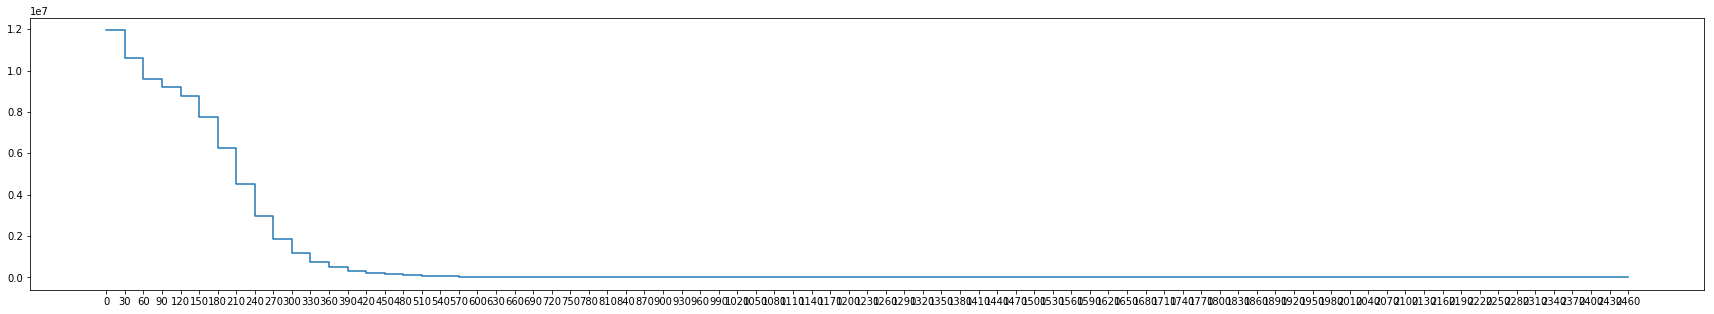

In [9]:
#plots ALL flights
[x_test, y_test] = step_plot_series(df_h.iloc[0,:-1].index, df_h.iloc[0,:-1].values) #.index grabs bins, excludes'zeros' computed in df_h, .values grabs freq
print(len(x_test), len(y_test))
plt.figure(figsize=(30,5))
# plt.xlim(0,25) #first 25 bins (7.5m), since computed all the way out to 25m (2500cm)
plt.plot(x_test, y_test)

In [10]:
fl_yrs = df_h.groupby(df_h.index.year).groups #.groups makes dictionary
# fl_yrs

In [13]:
print(fl_yrs.keys())
df_h.loc[fl_yrs[2018]]

dict_keys([2013, 2014, 2015, 2016, 2017, 2018])


,0,30,60,90,120,150,180,210,240,270,...,2220,2250,2280,2310,2340,2370,2400,2430,2460,zeros
2018-04-23,12216054,12723788,13868724,14580365,13291083,10696794,7787611,5254572,3297683,1982887,...,50,53,60,47,56,52,25,21,0,31629879
2018-05-28,9257357,7052135,6170597,4943048,3377909,2136899,1340373,846931,548966,366634,...,13,10,13,7,14,6,6,4,0,93955895


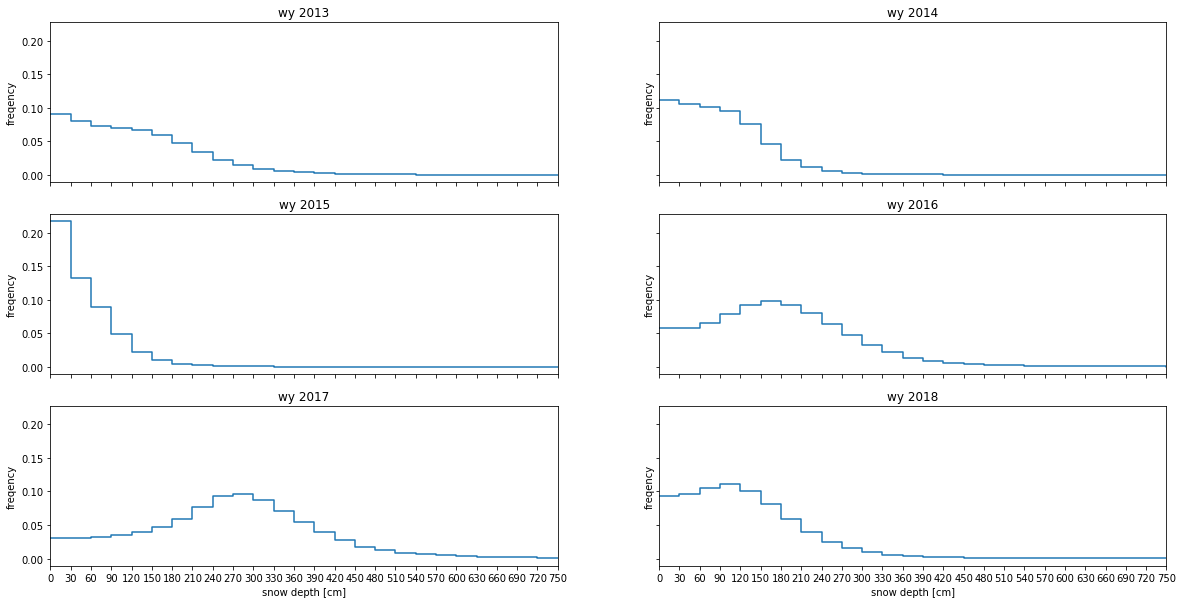

In [14]:
# attemp to plot each flight/year..... (make as peak swe date or something....)
years=range(2013,2019)
fig,axs=plt.subplots(nrows = 3, ncols = 2, sharex=True, sharey=True, figsize=(20,10))
axs=axs.flatten()

for i, year in enumerate(years):
    df_by_year = df_h.loc[fl_yrs[year]]
    [x_series, y_series] = step_plot_series(df_by_year.iloc[0,:-1].index, df_by_year.iloc[0,:-1].values, divide_value=131291738)#num_pix in mask=131,291,738
    plt.xlim(0,25) #first 25 bins (7.5m), since computed all the way out to 25m (2500cm)
    
    axs[i].plot(x_series, y_series)
    axs[i].set_title('wy {}'.format(year))
    axs[4].set_xlabel('snow depth [cm]');axs[5].set_xlabel('snow depth [cm]');
    axs[i].set_ylabel('freqency')
    
    #     plt.figure(figsize=(10,5))
    #     plt.title('wy {}'.format(year))
    #     plt.plot(x_series, y_series)
    #     plt.xlabel('snow depth [cm]');plt.ylabel('freqency')

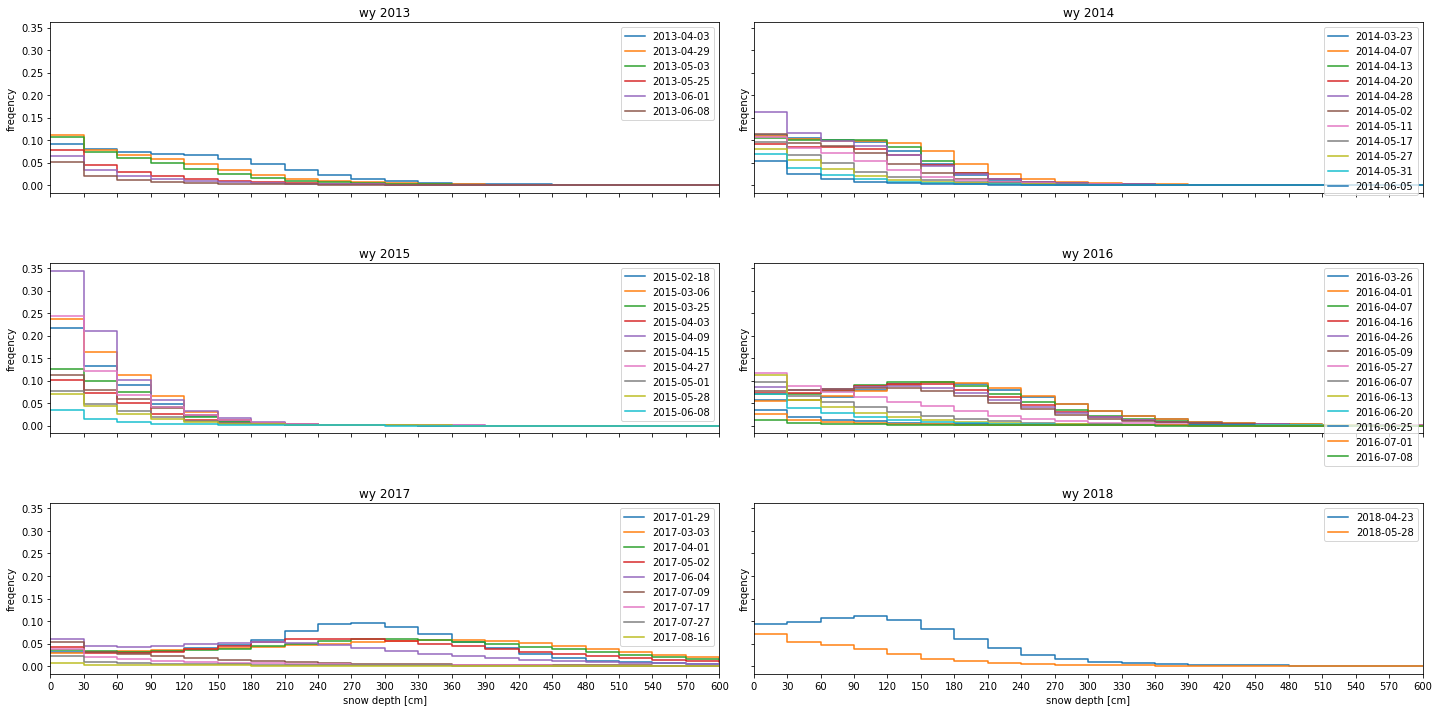

In [38]:
# plot each flight/year.....
years=range(2013,2019)
sum_mask = 131291738 #obtained from 3m_analysis.ipynb, sum of zeros and ones in tuolumne mask from topo.nc @ 3m cell size

fig,axs=plt.subplots(nrows = 3, ncols = 2, sharex=True, sharey=True, figsize=(20,10))
plt.xlim(0,20) #first 25 bins (7.5m), since computed all the way out to 25m (2500cm)
        # #color stuff
        # import matplotlib as mpl
        # n_lines = 5
        # c = np.arange(1, n_lines + 1)
        # norm = mpl.colors.Normalize(vmin=c.min(), vmax=c.max())
        # cmap = mpl.cm.ScalarMappable(norm=norm,cmap=mpl.cm.Blues)
        # cmap.set_array([])

axs=axs.flatten()

for i, year in enumerate(years):
    df_by_year = df_h.loc[:, df_h.columns != 'zeros'] #first, new df without 'zeros' column
    df_by_year = df_by_year.loc[fl_yrs[year]]
    
    for i2, row in enumerate(df_by_year.iterrows()):
        '''call step plot function'''
        [x_series, y_series] = step_plot_series(df_by_year.iloc[i2,:].index, df_by_year.iloc[i2,:].values, divide_value=sum_mask)

        '''plot it'''
#         print(df_by_year.index[i2].date())
        axs[i].plot(x_series, y_series, label='{}'.format(df_by_year.index[i2].date())) #,  c=cmap.to_rgba(i + 1))
        axs[i].set_title('wy {}'.format(year))
        axs[4].set_xlabel('snow depth [cm]');axs[5].set_xlabel('snow depth [cm]');
        axs[i].set_ylabel('freqency')
        axs[i].legend(loc='upper right')
plt.tight_layout()
plt.show()
    #     plt.figure(figsize=(10,5))
    #     plt.title('wy {}'.format(year))
    #     plt.plot(x_series, y_series)
    #     plt.xlabel('snow depth [cm]');plt.ylabel('freqency')

In [ ]:
#likely to delete

#~~~~~~~~~~~~~at home pre wr
# df_h.info()
#print(type(df_h.columns))
#df_h.columns.unique() #nunique for number unique
#df_h.groupby
# pd.to_datetime(df_h.columns[0]).strftime("%Y")
# df_h.groupb

#df_h.set_index(pd.to_datetime(df_h.index), inplace=True)
# for year in df_h:
#     plt.figure(figsize=(5,5))
#     df_h.column.plot.bar(width=0.85, align='edge')


#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
#~~~~~~~~~~~trying to plot
# df_nozeros  
#     for ax in axs.flat:
# #         df_h[column][:-1].plot.bar(width=0.85, align='edge')
#         df_nozeros[column].plot.bar(width=0.85, align='edge')
# #         bx = ax.plot.bar(df_nozeros)

# #     ax.set_title('{}'.format(years[z]))
#     # plot
# #     axs[i].plot.bar[df_nozeros]
#     plt.title('{}'.format(year))
    
# plt.tight_layout()
# plt.show() 
#~~~~~~
# fig = plt.figure(figsize=(15,10))

# for i, (name, row) in enumerate(df_h.loc[:, df_h.columns != 'zeros'].iterrows()):
#     ax = plt.subplot(i+1,1, i+1)
# #     print('name',name)
# #     print('row',row)

#      df_h[row][:-1].plot.bar(width=0.85, align='edge')
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

#~~~~~useful .iloc to plot dataframe way
# df_h.loc[:, df_h.columns != 'zeros'].plot()
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
